In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/Project

/content/drive/MyDrive/Project


In [3]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization,LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model

tf.random.set_seed(123)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
tf.random.set_seed(2)
np.random.seed(1)

# print(os.listdir("paintingdataset/dataset/dataset_updated/"))
print(os.listdir("fruitsdataset/archive/fruits-360_dataset/fruits-360/"))

['LICENSE', 'readme.md', 'papers', 'test-multiple_fruits', 'Test', 'Training']


In [4]:
# ImagePath="paintingdataset/dataset/dataset_updated/training_set/painting/"
ImagePath="fruitsdataset/archive/fruits-360_dataset/fruits-360/Training/"


In [5]:
ImagePath2="fruitsdataset/archive/fruits-360_dataset/fruits-360/Training/Apple Braeburn/"

(224, 224, 3)

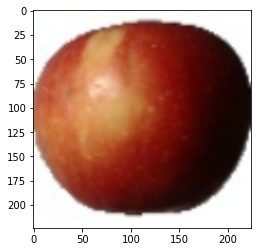

In [6]:
# img = cv2.imread(ImagePath+"1179.jpg")
img = cv2.imread(ImagePath2+"0_100.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
plt.imshow(img)
img.shape

In [7]:
HEIGHT=224
WIDTH=224

def ExtractInput(path):
    X_img=[]
    y_img=[]
    count = 0
    flag = 0
    for image_dir in os.listdir(ImagePath):
      for image_path in os.listdir(ImagePath + image_dir + '/'):
          try:
              count += 1
              if count == 2000: 
                flag = 1
                break
              img = cv2.imread(ImagePath + image_dir + '/' + image_path)
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
              # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
      
              img = img.astype(np.float32)
              img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
              #Convert the rgb values of the input image to the range of 0 to 1
              #1.0/255 indicates that we are using a 24-bit RGB color space.
              #It means that we are using numbers between 0–255 for each color channel
              #img_lab = 1.0/225*img_lab
              # resize the lightness channel to network input size 
              img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
              img_l = img_lab_rs[:,:,0] # pull out L channel
              #img_l -= 50 # subtract 50 for mean-centering
              img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
              img_ab = img_ab/128
              #The true color values range between -128 and 128. This is the default interval 
              #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
              X_img.append(img_l)
              y_img.append(img_ab)
          except:
              pass
      if flag == 1: break
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [ ]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [8]:
K.clear_session()
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = LeakyReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)

    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
    model_ = BatchNormalization()(model_)
    model_ = LeakyReLU()(model_)
    # model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = LeakyReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [ ]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [ ]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 16  160         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 224, 224, 16  0           ['conv2d_20[0][0]']              
                                )                                                           

In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,224,224,1)
        y_input = y_[i].reshape(1,224,224,2)
        yield (X_input,y_input)
history = Model_Colourization.fit(GenerateInputs(X_,y_),epochs=100,verbose=1,steps_per_epoch=5,shuffle=True)#,validation_data=GenerateInputs(X_val, y_val))

# Model_Colourization.save('colorization_model.h5')

Epoch 1/100
5/5 [==============================] - 2s 94ms/step - loss: 0.0216
Epoch 2/100
5/5 [==============================] - 0s 80ms/step - loss: 0.0050
Epoch 3/100
5/5 [==============================] - 0s 80ms/step - loss: 0.0027
Epoch 4/100
5/5 [==============================] - 0s 81ms/step - loss: 0.0020
Epoch 5/100
5/5 [==============================] - 0s 82ms/step - loss: 0.0014
Epoch 6/100
5/5 [==============================] - 0s 81ms/step - loss: 0.0010
Epoch 7/100
5/5 [==============================] - 0s 80ms/step - loss: 0.0011
Epoch 8/100
5/5 [==============================] - 0s 81ms/step - loss: 7.2326e-04
Epoch 9/100
5/5 [==============================] - 0s 81ms/step - loss: 6.8368e-04
Epoch 10/100
5/5 [==============================] - 0s 83ms/step - loss: 6.5191e-04
Epoch 11/100
5/5 [==============================] - 0s 80ms/step - loss: 5.7083e-04
Epoch 12/100
5/5 [==============================] - 0s 80ms/step - loss: 5.4448e-04
Epoch 13/100
5/5 [===========

In [ ]:
print(history.history.keys())

dict_keys(['loss'])


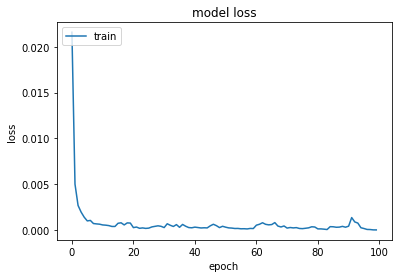

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
Model_Colourization.save('colorization_model.h5')

In [ ]:
%ls

 AlexNet.ipynb                     image-colourisation/
'Animal Colorization.ipynb'        landscapedataset/
 animalsdataset/                  'Lanscape Colorization.ipynb'
 antelope_colorization_model.h5   'Literature Review.gdoc'
 buildings_colorization_model.h5  'Literature Review papers'/
 Colorization.ipynb               'Milestone Report.gdoc'
 colorization_model.h5             paintingdataset/
 cvpr2021AuthorKit_2/              Proposal.gdoc
 fruitsdataset/                   'Research Papers'/
 Ideas.gdoc


In [9]:
Model_Colourization = load_model('colorization_model.h5')

Testing

In [10]:
# TestImagePath="paintingdataset/dataset/dataset_updated/training_set/iconography/"
TestImagePath="fruitsdataset/archive/fruits-360_dataset/fruits-360/Test/Apple Braeburn/"


In [16]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,224,224,1)
    
    return img_l_reshaped

In [17]:
ImagePath_test=TestImagePath+"2_100.jpg"
image_for_test = ExtractTestInput(ImagePath_test)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*128
Prediction=Prediction.reshape(224,224,2)

error: ignored

NameError: ignored

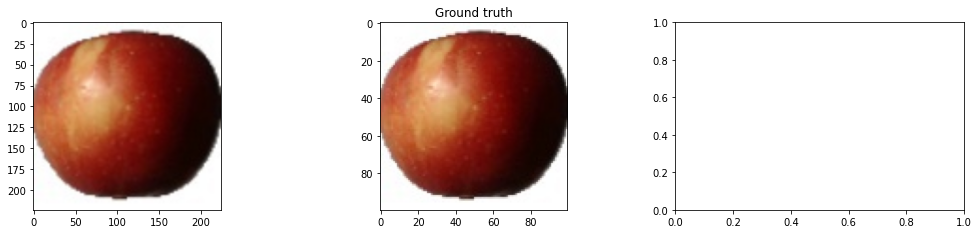

In [13]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath+"3_100.jpg")
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
# img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img_1, (224, 224))
plt.imshow(img)

plt.subplot(5,5,1+1)
plt.title("Ground truth")
plt.imshow(img_1)

plt.subplot(5,5,1+2)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)
